In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# 1. Load Dataset

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
df = pd.read_csv(url)

print("Shape:", df.shape)
df.head()

Shape: (440, 8)


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


# 2. Select Numeric Features


In [3]:
X = df.drop(["Region", "Channel"], axis=1)

# 3. Scaling


In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Determine eps Using K-Distance Graph


In [5]:
neighbors = 5
nn = NearestNeighbors(n_neighbors=neighbors)
nn_fit = nn.fit(X_scaled)
distances, indices = nn_fit.kneighbors(X_scaled)

## Sort distances


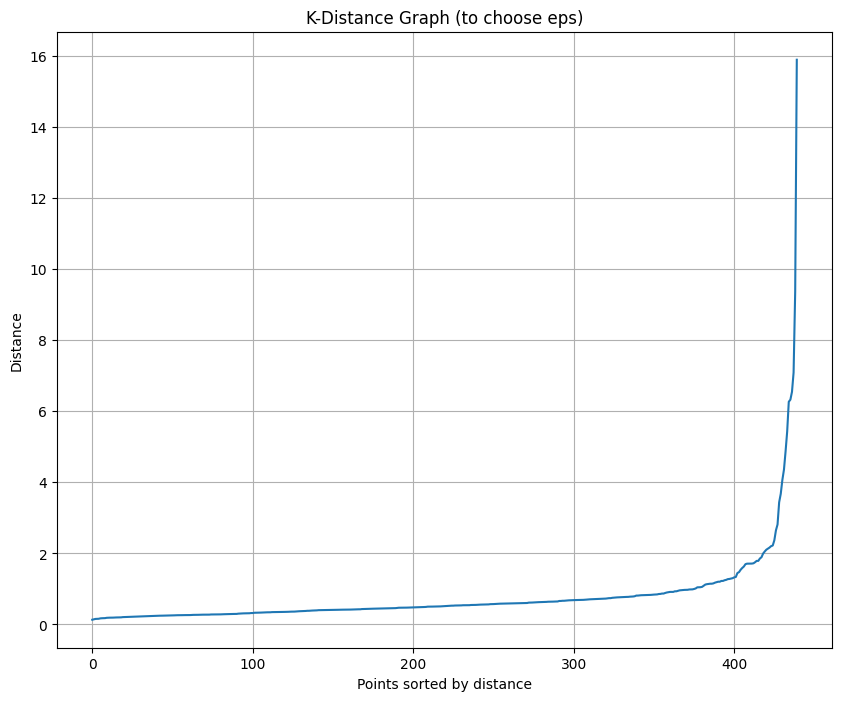

In [6]:
distance_desc = np.sort(distances[:, neighbors - 1])

plt.figure(figsize=(10, 8))
plt.plot(distance_desc)
plt.title("K-Distance Graph (to choose eps)")
plt.xlabel("Points sorted by distance")
plt.ylabel("Distance")
plt.grid()
plt.show()

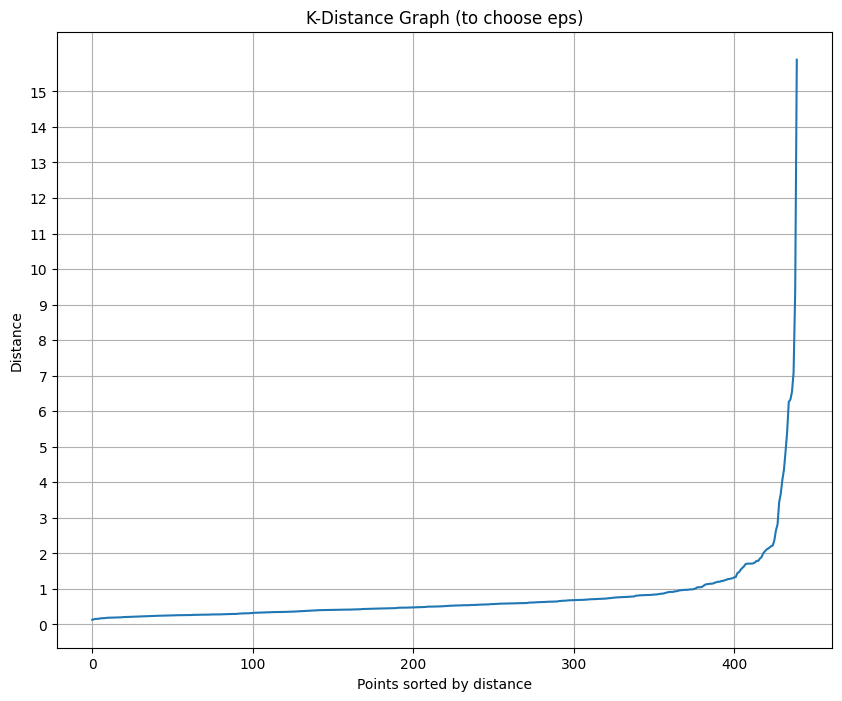

In [7]:
distance_desc = np.sort(distances[:, neighbors - 1])

plt.figure(figsize=(10, 8))
plt.plot(distance_desc)
plt.yticks(ticks=range(0, 16, 1))
plt.title("K-Distance Graph (to choose eps)")
plt.xlabel("Points sorted by distance")
plt.ylabel("Distance")
plt.grid()
plt.show()

In [8]:
eps_values = [0.5, 0.8, 1.0, 1.2, 1.5]

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(X_scaled)
    print(f"eps={eps} → clusters={set(labels) - {-1}}, anomalies={list(labels).count(-1)}")


eps=0.5 → clusters={0, 1}, anomalies=174
eps=0.8 → clusters={0}, anomalies=74
eps=1.0 → clusters={0}, anomalies=47
eps=1.2 → clusters={0}, anomalies=38
eps=1.5 → clusters={0}, anomalies=27


# 5. Apply DBSCAN


In [9]:
db = DBSCAN(eps=1.2, min_samples=5)
labels = db.fit_predict(X_scaled)

df["cluster"] = labels
df["anomaly"] = df["cluster"] == -1

print("Number of anomalies:", df["anomaly"].sum())
print("Clusters found (excluding -1):", set(labels) - {-1})


Number of anomalies: 38
Clusters found (excluding -1): {0}


# 6. Reduce to 2D for Visualization (PCA)


In [10]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df["pca1"] = X_pca[:, 0]
df["pca2"] = X_pca[:, 1]


# 7. Plot Clusters vs Anomalies


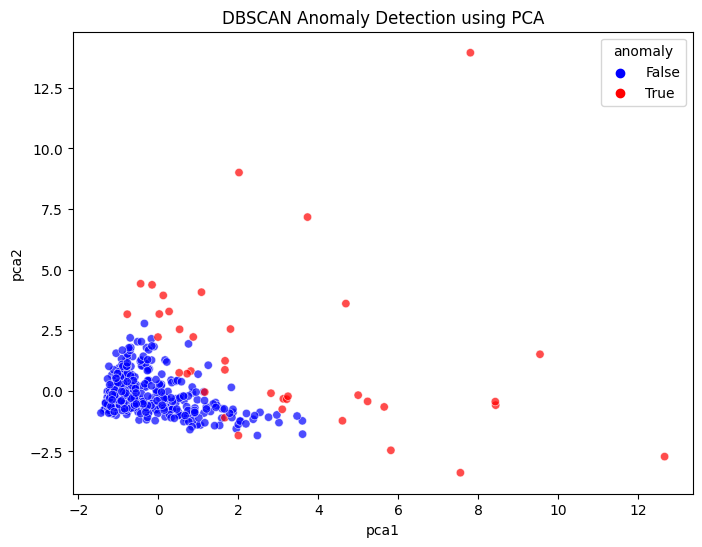

In [11]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="pca1", y="pca2",
    hue="anomaly",
    palette={False: "blue", True: "red"},
    alpha=0.7
)
plt.title("DBSCAN Anomaly Detection using PCA")
plt.show()


# 8. Save Results


In [12]:
df.to_csv("dbscan_anomaly_results.csv", index=False)
print("Saved: dbscan_anomaly_results.csv")

df.head()

Saved: dbscan_anomaly_results.csv


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster,anomaly,pca1,pca2
0,2,3,12669,9656,7561,214,2674,1338,0,False,0.193291,-0.305100
1,2,3,7057,9810,9568,1762,3293,1776,0,False,0.434420,-0.328413
2,2,3,6353,8808,7684,2405,3516,7844,-1,True,0.811143,0.815096
3,1,3,13265,1196,4221,6404,507,1788,0,False,-0.778648,0.652754
4,2,3,22615,5410,7198,3915,1777,5185,0,False,0.166287,1.271434
